# 사전 자료 3

본 자료는 LG AI CAMP의 `LG Vision Module3`를 위한 세 번째 사전 자료입니다.

Pytorch를 사용하여 신경망을 학습하는 것에 아직 미숙함을 가지고 계실 분들을 위해 만들어본 자료입니다.

본 자료는 아래 분들의 자료를 참고하여 만들었습니다.

Copyright @ cb_park@korea.ac.kr (Cheonbok Park), joonleesky@kaist.ac.kr (Hojoon Lee)

## MNIST 데이터 학습을 위한 신경망 학습

torch와 관련된 library의 import

In [1]:
import torch 
import torch.nn as nn #
import torch.nn.functional as F # various activation functions for model
import torchvision # You can load various Pretrained Model from this package 
import torchvision.datasets as vision_dsets
import torchvision.transforms as T # Transformation functions to manipulate images
import torch.optim as optim # various optimization functions for model


from torch.autograd import Variable 
from torch.utils import data

데이터 분석을 위한 library의 import

In [2]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

## Confusion Matrix (오차행렬)

### Confusion matrix란?
- Training을 통한 Prediction 성능을 예측 value와 실제 value를 비교하기 위한 표

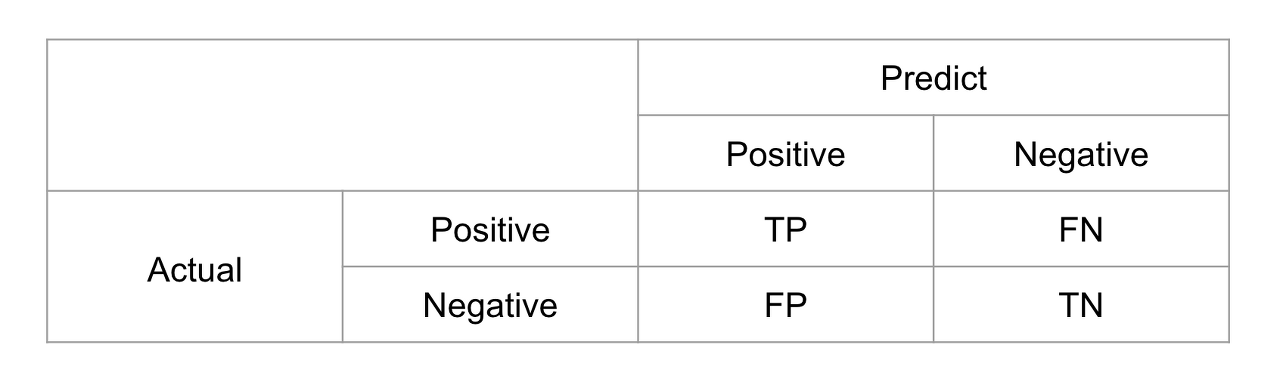

https://shinminyong.tistory.com/m/28 의 설명을 빌려와 설명하겠습니다.

### 자세한 설명

먼저 표 내부에 있는 단어들에 대한 설명을 드리겠습니다.(설명의 편의성을 위해서 환자다 / 환자가 아니다 로 설명드리겠습니다.)

Actual(Positive) : 실제 환자
Actual(Negative) : 실제 환자가 아님
Predict(Positive) : 실제 환자로 예측
Predict(Negative) : 환자가 아닌 것으로 예측
이번엔 각각의 교차된 지표에 대해서 설명드리겠습니다. 이 부분은 앞의 단어를 성공/실패 뒤의 단어를 긍정예측/부정예측 이라고 생각하시면 생각하시기 쉬울겁니다!

TP(True Positive) : 긍정예측을 성공 즉, 환자라고 예측해서 실제 환자임을 맞춤
TN(True Negative) : 부정예측을 성공 즉, 비환자라고 예측하여 실제 비환자임을 맞춤
FP(False Positive) : 긍정예측을 실패 즉, 환자라고 예측했지만 비환자임
FN(False Negative) : 부정예측을 실패 즉, 비환자라고 예측했지만 실제 환자임

In [3]:
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(20, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## DataLoader의 생성

MNIST Data의 경우 Pytorch의 torchvision에 이미 있는 데이터 셋입니다. 그리하여 torchvision으로부터 dataset을 받아오고, 받아온 데이터 셋을 원하는 batch size와 transform함수를 통해 data loader로 아래 처럼 만들어줍니다.

더욱 자세한 설명은 https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader 을 참고하시면 됩니다.

In [4]:
def MNIST_DATA(root='./data',train =True,transforms=None ,download =True,batch_size = 32,num_worker = 1):
    print ("[+] Get the MNIST DATA")
    """
    We will use Mnist data for our tutorial 
    """
    mnist_train = vision_dsets.MNIST(root = root,  #root is the place to store your data. 
                                    train = True,  
                                    transform = T.ToTensor(), # convert data to tensor 
                                    download = True)  # whether to download the data
    mnist_test = vision_dsets.MNIST(root = root,
                                    train = False, 
                                    transform = T.ToTensor(),
                                    download = True)
    """
    Data Loader is a iterator that fetches the data with the number of desired batch size. 
    * Practical Guide : What is the optimal batch size? 
      - Usually.., higher the batter. 
      - We recommend to use it as a multiple of 2 to efficiently utilize the gpu memory. (related to bit size)
    """
    trainDataLoader = data.DataLoader(dataset = mnist_train,  # information about your data type
                                      batch_size = batch_size, # batch size
                                      shuffle =True, # Whether to shuffle your data for every epoch. (Very important for training performance)
                                      num_workers = 1) # number of workers to load your data. (usually number of cpu cores)

    testDataLoader = data.DataLoader(dataset = mnist_test, 
                                    batch_size = batch_size,
                                    shuffle = False, # we don't actually need to shuffle data for test
                                    num_workers = 1) #
    print ("[+] Finished loading data & Preprocessing")
    return mnist_train,mnist_test,trainDataLoader,testDataLoader

In [5]:
trainDset,testDset,trainDataLoader,testDataLoader= MNIST_DATA(batch_size = 32)  # Data Loader 

[+] Get the MNIST DATA


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
[+] Finished loading data & Preprocessing


/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


## Define Trainer

Trainer를 class로 만든 것입니다. 목적은 net, trainloader, testloader, optimizer, criterion을 모두 input으로 받아, Trainer 내에서 모델의 학습과 평가를 하기 위함입니다.

In [6]:
class Trainer():
    def __init__(self, trainloader, testloader, net, optimizer, criterion):
        """
        trainloader: train data's loader
        testloader: test data's loader
        net: model to train
        optimizer: optimizer to update your model
        criterion: loss function
        """
        self.trainloader = trainloader
        self.testloader = testloader
        self.net = net
        self.optimizer = optimizer
        self.criterion = criterion
        
    def train(self, epoch = 1):
        """
        epoch: number of times each training sample is used
        """
        self.net.train()
        for e in range(epoch):
            running_loss = 0.0  
            for i, data in enumerate(self.trainloader, 0): 
                # get the inputs
                inputs, labels = data # Return type for data in dataloader is tuple of (input_data, labels)
                inputs = inputs.cuda()
                labels = labels.cuda()
                # zero the parameter gradients
                self.optimizer.zero_grad()    
                #  Q1) waht if we dind't clear up the gradients?

                # forward + backward + optimize
                outputs = self.net(inputs) # get output after passing through the network
                loss = self.criterion(outputs, labels) # compute model's score using the loss function 
                loss.backward() # perform back-propagation from the loss
                self.optimizer.step() # perform gradient descent with given optimizer

                # print statistics
                running_loss += loss.item()
                if (i+1) % 500 == 0:    # print every 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' % (e + 1, i + 1, running_loss / 500))
                    running_loss = 0.0

        print('Finished Training')
        
    def test(self):
        self.net.eval() # Q2) Why should we change the network into eval-mode?
                        # -
        test_loss = 0
        correct = 0
        for inputs, labels in self.testloader:
            inputs = inputs.cuda()
            labels = labels.cuda() 
            output = self.net(inputs) 
            pred = output.max(1, keepdim=True)[1] # get the index of the max 
            correct += pred.eq(labels.view_as(pred)).sum().item()

            test_loss /= len(self.testloader.dataset)
        print('\nTest set:  Accuracy: {}/{} ({:.0f}%)\n'.
                format(correct, len(self.testloader.dataset),
                100.* correct / len(self.testloader.dataset)))
        
    def get_conf(self):
        self.net.eval()
        
        confusion = torch.zeros(10,10)
        for inputs, labels in self.testloader:
            inputs = inputs.cuda()
            labels = labels.cuda()
            output = self.net(inputs)
            pred = torch.argmax(output, dim=1)
            
            for num in range(output.shape[0]):
                confusion[pred[num], labels[num]] += 1
        
        return confusion

## Let's create Model by yourself

![activation](./imgs/activation.png)

### (1) 2-Layer Network + Sigmoid

- Input: (28 * 28)
- Hidden dimension: 30
- Output dimension: 10
- activation: sigmoid
- Optimizer: SGD
- Loss: Cross-Entropy

In [125]:
class MNIST_Net(nn.Module): 
    def __init__(self):
        super(MNIST_Net, self).__init__() # Q3) Why do we need to call the constructor, nn.Module?
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) # x.view convert the shape of tensor, (Batch_size,28,28) --> (Batch_size,28*28)
        x = self.fc0(x) # 28*28 -> 30 
        x = F.sigmoid(x) # Activation function 
        x = self.fc1(x)  # 30 -> 10, logit for each class
        return x

In [126]:
mnist_net = MNIST_Net().cuda() # create the neural network instance and load to the cuda memory.
criterion = nn.CrossEntropyLoss() # Define Loss Function. We use Cross-Entropy loss.
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001) # optimizer receives training parameters and learning rate.

In [127]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [128]:
trainer.train(epoch = 4)

[1,   500] loss: 2.339
[1,  1000] loss: 2.299
[1,  1500] loss: 2.279
[2,   500] loss: 2.250
[2,  1000] loss: 2.236
[2,  1500] loss: 2.221
[3,   500] loss: 2.198
[3,  1000] loss: 2.181
[3,  1500] loss: 2.167
[4,   500] loss: 2.140
[4,  1000] loss: 2.120
[4,  1500] loss: 2.100
Finished Training


In [129]:
trainer.test()


Test set:  Accuracy: 5769/10000 (58%)



/home/taehyeon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


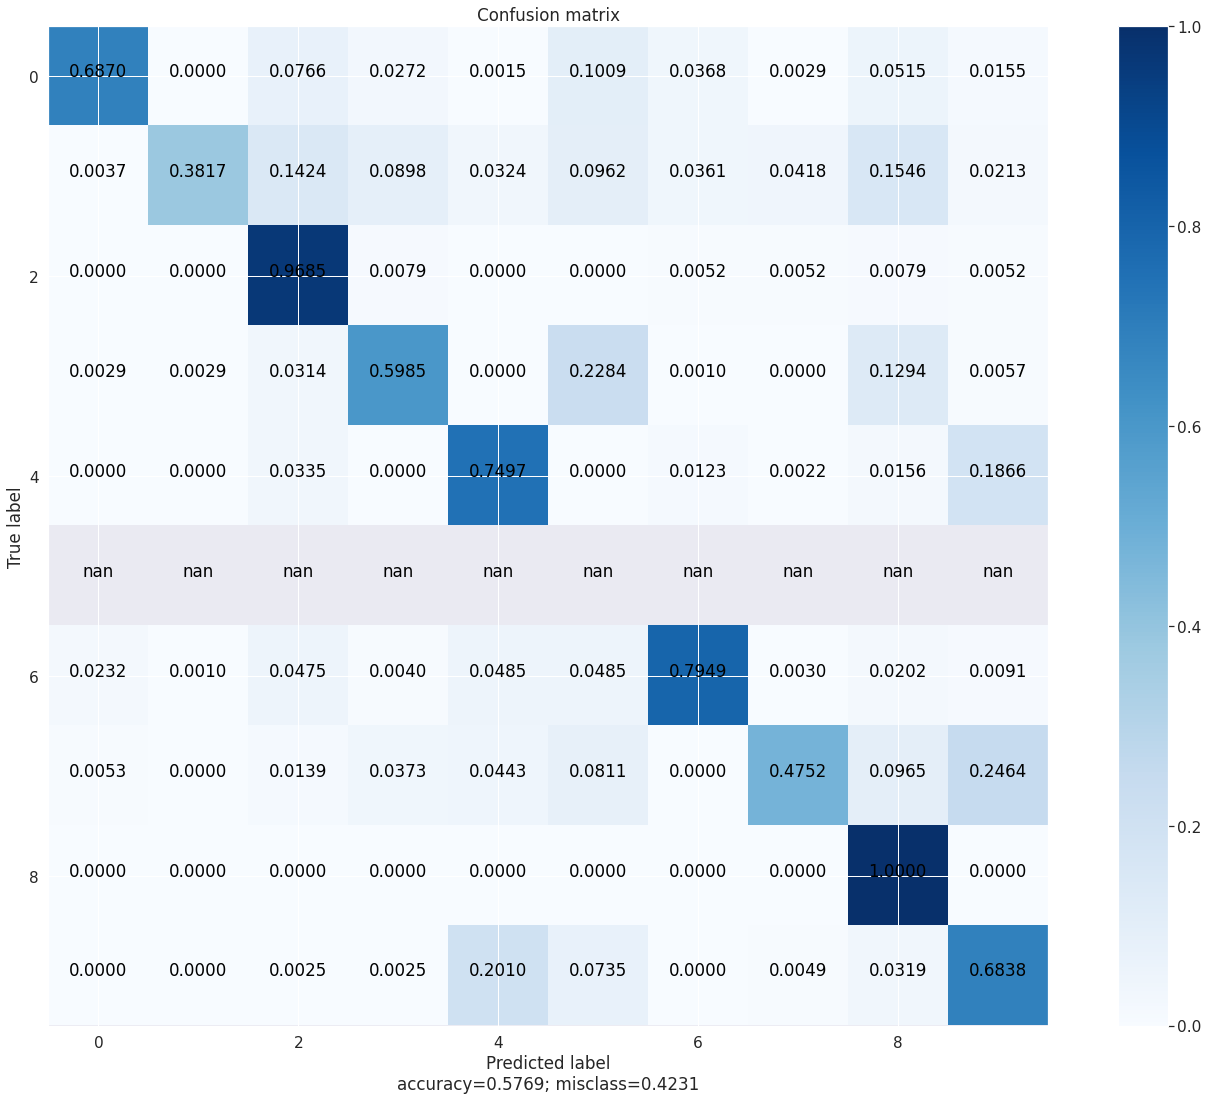

In [130]:
plot_confusion_matrix(trainer.get_conf().numpy())

### (2) 2-Layer Network + ReLU

- Input: (28 * 28)
- Hidden dimension: 30
- Output dimension: 10
- activation: relu
- Optimizer: SGD
- Loss: Cross-Entropy

In [131]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = F.relu(x) # Activation function
        x = self.fc1(x)  # 30 -> 10
        return x

In [132]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001)

In [133]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [134]:
trainer.train(epoch = 4)

[1,   500] loss: 2.262
[1,  1000] loss: 2.172
[1,  1500] loss: 2.057
[2,   500] loss: 1.825
[2,  1000] loss: 1.680
[2,  1500] loss: 1.535
[3,   500] loss: 1.287
[3,  1000] loss: 1.170
[3,  1500] loss: 1.074
[4,   500] loss: 0.916
[4,  1000] loss: 0.873
[4,  1500] loss: 0.812
Finished Training


In [135]:
trainer.test()


Test set:  Accuracy: 8419/10000 (84%)



### (3) 3-Layer Network + Sigmoid

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: sigmoid
- Optimizer: SGD
- Loss: Cross-Entropy

In [70]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = F.sigmoid(x)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        return x

In [71]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001)  

In [72]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [73]:
trainer.train(epoch = 4)

/home/taehyeon/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,   500] loss: 2.330
[1,  1000] loss: 2.316
[1,  1500] loss: 2.308
[2,   500] loss: 2.301
[2,  1000] loss: 2.300
[2,  1500] loss: 2.299
[3,   500] loss: 2.299
[3,  1000] loss: 2.298
[3,  1500] loss: 2.298
[4,   500] loss: 2.298
[4,  1000] loss: 2.297
[4,  1500] loss: 2.297
Finished Training


In [74]:
trainer.test()


Test set:  Accuracy: 1135/10000 (11%)



### (4) 3-Layer Network + ReLU

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: relu
- Optimizer: SGD
- Loss: Cross-Entropy

In [75]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [76]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001) 

In [77]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [78]:
trainer.train(epoch = 4)

[1,   500] loss: 2.302
[1,  1000] loss: 2.291
[1,  1500] loss: 2.275
[2,   500] loss: 2.234
[2,  1000] loss: 2.204
[2,  1500] loss: 2.163
[3,   500] loss: 2.062
[3,  1000] loss: 1.983
[3,  1500] loss: 1.887
[4,   500] loss: 1.674
[4,  1000] loss: 1.529
[4,  1500] loss: 1.382
Finished Training


In [79]:
trainer.test()


Test set:  Accuracy: 7503/10000 (75%)



### (5) 3-Layer Network + ReLU + Adam

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: relu
- Optimizer: Adam
- Loss: Cross-Entropy

In [80]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [81]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

In [82]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [83]:
trainer.train(epoch = 4)

[1,   500] loss: 0.683
[1,  1000] loss: 0.296
[1,  1500] loss: 0.234
[2,   500] loss: 0.185
[2,  1000] loss: 0.167
[2,  1500] loss: 0.161
[3,   500] loss: 0.121
[3,  1000] loss: 0.130
[3,  1500] loss: 0.124
[4,   500] loss: 0.099
[4,  1000] loss: 0.099
[4,  1500] loss: 0.103
Finished Training


In [84]:
trainer.test()


Test set:  Accuracy: 9687/10000 (97%)



### (6) 2-Layer Network + ReLU + Adam

- Input: (28 * 28)
- Hidden dimension: (30)
- Output dimension: 10
- activation: relu
- Optimizer: Adam
- Loss: Cross-Entropy

In [85]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = F.relu(x) 
        x = self.fc1(x) 
        return x

In [86]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

In [87]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [88]:
trainer.train(epoch = 4)

[1,   500] loss: 0.702
[1,  1000] loss: 0.313
[1,  1500] loss: 0.287
[2,   500] loss: 0.222
[2,  1000] loss: 0.224
[2,  1500] loss: 0.207
[3,   500] loss: 0.182
[3,  1000] loss: 0.163
[3,  1500] loss: 0.164
[4,   500] loss: 0.148
[4,  1000] loss: 0.143
[4,  1500] loss: 0.137
Finished Training


In [89]:
trainer.test()


Test set:  Accuracy: 9562/10000 (96%)



## Batch-Normalization

![normalization](./imgs/normalization.png)

Reference: Andrew Ng, Deep Learning

### (7) 2-Layer Network + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Hidden dimension: (30)
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

In [90]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.bn0 = nn.BatchNorm1d(30) # BatchNorm 
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = self.bn0(x)
        x = F.relu(x) 
        x = self.fc1(x)   
        return x

In [91]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)  

In [92]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [93]:
trainer.train(epoch = 4)

[1,   500] loss: 0.709
[1,  1000] loss: 0.340
[1,  1500] loss: 0.273
[2,   500] loss: 0.221
[2,  1000] loss: 0.207
[2,  1500] loss: 0.193
[3,   500] loss: 0.161
[3,  1000] loss: 0.166
[3,  1500] loss: 0.163
[4,   500] loss: 0.146
[4,  1000] loss: 0.145
[4,  1500] loss: 0.141
Finished Training


In [94]:
trainer.test()


Test set:  Accuracy: 9641/10000 (96%)



### (8) 3-Layer Network + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

In [95]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.bn0 = nn.BatchNorm1d(50) # BatchNorm 1 
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.bn1 = nn.BatchNorm1d(30) # BatchNorm 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = self.bn0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [96]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)

In [97]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [98]:
trainer.train(epoch = 4)

[1,   500] loss: 0.634
[1,  1000] loss: 0.249
[1,  1500] loss: 0.201
[2,   500] loss: 0.148
[2,  1000] loss: 0.149
[2,  1500] loss: 0.140
[3,   500] loss: 0.116
[3,  1000] loss: 0.111
[3,  1500] loss: 0.111
[4,   500] loss: 0.099
[4,  1000] loss: 0.101
[4,  1500] loss: 0.099
Finished Training


In [99]:
trainer.test()


Test set:  Accuracy: 9713/10000 (97%)



In [147]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(mnist_net)

85490

### Convolution Operation

![Convolution](./imgs/Conv.png)



### (9) 3-Layer Network (Conv+Fc) + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Conv: 8 (6 * 6) filter with stride=2 
- Hidden dimension: 8 * 12 * 12
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

In [148]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = 1,
                               out_channels = 8,
                               kernel_size = 6,
                               stride = 2) # Layer 1
        self.conv0_bn = nn.BatchNorm2d(8)  # 2d batch-norm is used in 3d inputs
        self.fc = nn.Linear(8*12*12, 10)   # Layer 2 

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv0_bn(x)
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [149]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)

In [150]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [151]:
trainer.train(epoch = 4)

[1,   500] loss: 0.378
[1,  1000] loss: 0.158
[1,  1500] loss: 0.123
[2,   500] loss: 0.087
[2,  1000] loss: 0.080
[2,  1500] loss: 0.083
[3,   500] loss: 0.064
[3,  1000] loss: 0.065
[3,  1500] loss: 0.066
[4,   500] loss: 0.047
[4,  1000] loss: 0.058
[4,  1500] loss: 0.058
Finished Training


In [152]:
trainer.test()


Test set:  Accuracy: 9801/10000 (98%)



In [153]:
count_parameters(mnist_net)

11842

### (10) 3-Layer Network (Conv+Pool+Fc) + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Conv: 8 (7 * 7) filter with stride=2 
- Pool: 2 * 2
- Hidden dimension: 8 * 6 * 6
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

### Pooling Operation

![Pooling](./imgs/Pool.png)



In [154]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = 1,
                               out_channels = 8,
                               kernel_size = 6,
                               stride = 2) # Layer 1
        self.conv0_bn = nn.BatchNorm2d(8)  
        self.pool0 = nn.MaxPool2d(2)
        self.fc = nn.Linear(8*6*6, 10) 

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv0_bn(x)
        x = F.relu(x)
        x = self.pool0(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [155]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

In [156]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [157]:
trainer.train(epoch = 4)

[1,   500] loss: 0.561
[1,  1000] loss: 0.190
[1,  1500] loss: 0.140
[2,   500] loss: 0.096
[2,  1000] loss: 0.099
[2,  1500] loss: 0.086
[3,   500] loss: 0.078
[3,  1000] loss: 0.077
[3,  1500] loss: 0.076
[4,   500] loss: 0.069
[4,  1000] loss: 0.072
[4,  1500] loss: 0.068
Finished Training


In [158]:
trainer.test()


Test set:  Accuracy: 9790/10000 (98%)



In [159]:
count_parameters(mnist_net)

3202